# Housing Data Analysis with Linear Regression

## Overview

For this project I'll be using the Kings County housing dataset to solve a housing-related business problem using linear regression techniques.
I'll be using the CRISP-DM Data Science method which the structure this notebook will follow, demonstrating an iterative modeling process with feature engineering, model fit, evaluation, and further data processing until the model proves to be useful to my business case. 

<img src="Images/new_crisp-dm.png" width=400>

## Business Understanding

A housing development company is working on new model homes. They want to design houses that will sell to middle class buyers who are currently facing a shortage of available and affordable inventory due to the increase in demand during 2020.

The median national home listing price grew by 13.4% over last year nationally, and The Seattle-Tacoma-Bellevue metro area saw YoY listing prices rise 7.8% with a median price of $627,500. Meanwhile, there was a 35.6% decrease in listings. So less houses available and higher prices. 

The developers would like understand which features a home should include at the median price range so that they can appropriately design new homes to replenish inventory and sell to a consumer group that currently has high demand.

source: https://www.realtor.com/research/december-2020-data/

## Data Understanding

This data includes house sale prices and conditions from houses sold through 2014-2015 in the Seattle area. These houses were built as early as 1900 and as late as 2015. The data includes several variables that describe the house, its location, and its condition. 

I'm going to start by importing all my libraries and loading the data into a dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

### Defining My Target

Knowing that my stakeholders are aiming to sell to buyers that are looking within a certain price range, I'll have to define a range of the data I am using for my model. By examining the distribution of values, I can see there are outliers on the higher end that could skew my model by including all these houses that go up to \$7MM sale prices. As a reminder, the median house price in the area in 2020 was \$627k. I'll use a box plot to examine the distribution of prices in my data.

In [4]:
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

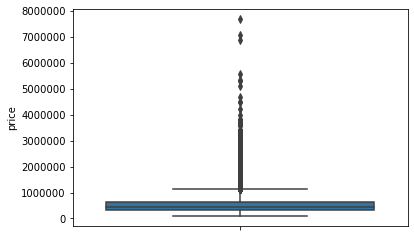

In [3]:
sns.boxplot(data['price'], orient='v')

All the outliers are on the higher end, skewing the data. Since the 75% bound is close to the median price in 2020, I'm going to redefine the data to 2 standard deviations above and below that.

In [5]:
y_range = ((data['price'].std()*2) - 645000), (645000 + (data['price'].std()*2))
y_range

(89736.280202789, 1379736.280202789)

In [6]:
new_data = data[data['price'].between(y_range[0], y_range[1])]

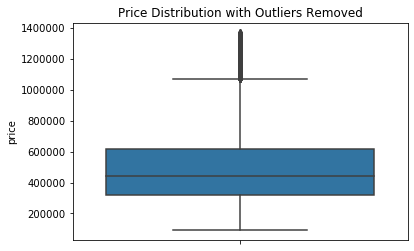

In [7]:
#boxplot with newly defined range
sns.boxplot(new_data['price'], orient='v')
plt.title('Price Distribution with Outliers Removed')
# plt.savefig('Images/y_dist')

Even with that, there are still a lot of outliers so I am going to filter out the outliers outside the upper bound of the boxplot.

In [8]:
new_data = new_data.loc[new_data['price'] <= 1150000]

In [10]:
new_data['price'].describe()

count    2.050200e+04
mean     4.793161e+05
std      2.110772e+05
min      8.995000e+04
25%      3.150000e+05
50%      4.390000e+05
75%      6.050000e+05
max      1.150000e+06
Name: price, dtype: float64

In [11]:
(data.shape[0] - new_data.shape[0])/ data.shape[0]

0.050701486317544106

That filtering only eliminated 5% of the original data so there is still a significant amount to work with. The data now falls within a realistic range for my potential buyer, but the mean is a bit lower than the median market price I referenced earlier. Looking at the distribution of the data again, it's really skewed toward the lower end. I'll keep this in mind when running model analyses. 

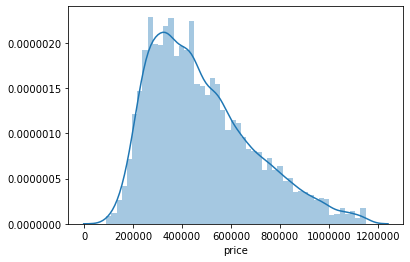

In [9]:
sns.distplot(new_data['price'])

## Data Preparation

### Data Cleaning
To prepare my data to fit to a model, I'll have to clean out anything the model can't read or that is clearly inaccurate/irrelevant. Previewing the data I can see there are some null values I'll have to deal with. These are coming from yr_renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely.

For Waterfront and View:

 - There are only 146 houses that are coded as waterfront. I don't want to drop nulls because there are over 2K, so I am going to fill the null values with 0 since it won't affect the distribution much.
 
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature since I am building new houses, not selling ones that are on the market. I am going to fill these nulls with a 0 assuming they were not available to view, but I am not going to include this feature for now.


In [12]:
new_data['waterfront'].fillna(0.0, inplace=True)
new_data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [13]:
new_data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
new_data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in new_data.index:
    if new_data['yr_renovated'][row] != 0.0:
        new_data['is_renovated'][row] = 1

Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [14]:
#use lambda function to replace all the symbols, and then make sure the column is read as on integer
new_data['sqft_basement'] = new_data['sqft_basement'].map(lambda x: x.replace("?", "0"))
new_data['sqft_basement'] = pd.to_numeric(new_data['sqft_basement'], downcast='integer')

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that costs only $640k.

In [15]:
new_data[new_data.bedrooms == new_data.bedrooms.max()]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
15856      6000     1.0         0.0   0.0  ...        1040            580   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
15856      1947           0.0    98103  47.6878 -122.331           1330   

       sqft_lot15  is_renovated  
15856        4700             0  

[1 rows x 22 columns]

In [16]:
new_data = new_data.drop([15856], axis=0)

### Preprocessing

Now I am going to examine the data to see how it will need to be processed to fit to a model. 

First I'm going to separate my continuous from categorical columns so I can treat each type appropriately. I am excluding ID, date and the sqft 15 columns. The dates are all from the same 2 years so there isn't a diverse amount of data - it basically just tells me that all these houses were sold. The neighboring house info is not relevant since my stakeholders are working on a new development for which they'll design neighboring houses.

I'm separating out latitude and longitude since they are technically continuous but can't be treated the same way as other continuous variables.

In [17]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
geo_cols= ['lat', 'long']
y = new_data['price']
X_cols = new_data[cat_cols + con_cols + geo_cols]

Then I'm going to run a few visual techniques to take a look at my data and see what features I may need to address for modeling. First, I'm running pair plots to see if there's any obvious correlations between the X variables and y that can be seen visually.

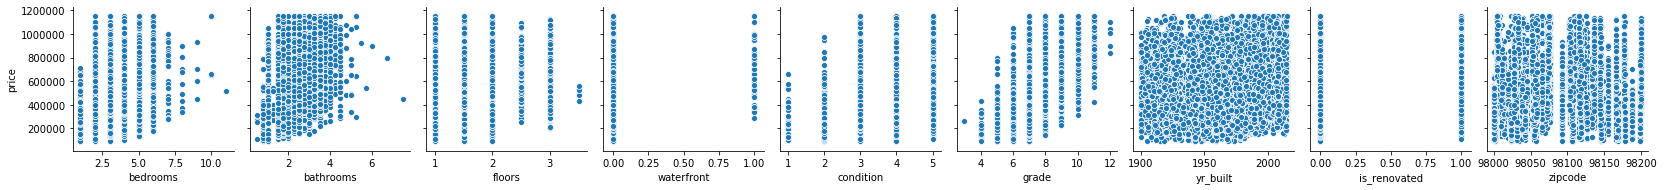

In [18]:
sns.pairplot(new_data,
    x_vars=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'is_renovated', 'zipcode'],
    y_vars=['price'])

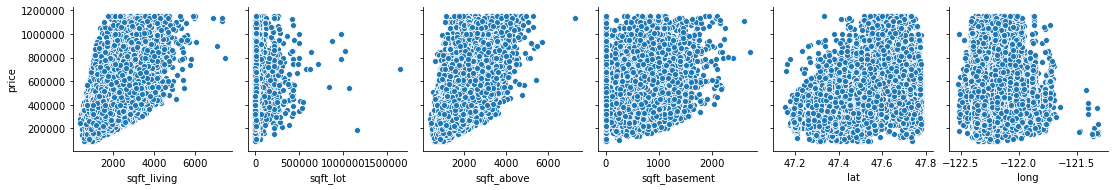

In [19]:
sns.pairplot(new_data,
    x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long'],
    y_vars=['price'])

From the categoricals, grade seems to be the only one tht somewhat affects price. Bedrooms and bathrooms appear to have a limited effect. 

From the continuous variables, square feet appears to have an affect to a certain point. Lat and log do not, but there are more effective ways to look at those since they don't truly represent a value.

I'm going to examine the continuous variables to see their distributions. 

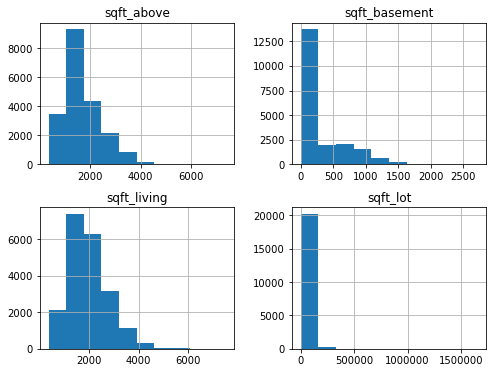

In [20]:
#running a histogram to examine the distribution of continuous columns
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
new_data[con_cols].hist(ax = ax);

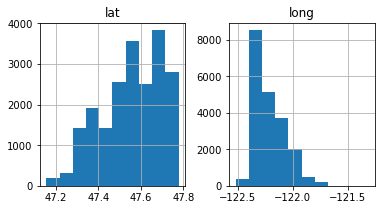

In [21]:
#running a histogram to examine the distribution of lat & long columns
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
new_data[geo_cols].hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them.

Now I want to look for high multicollinearity. I'll use a heat map of all the columns.

(16, 0)

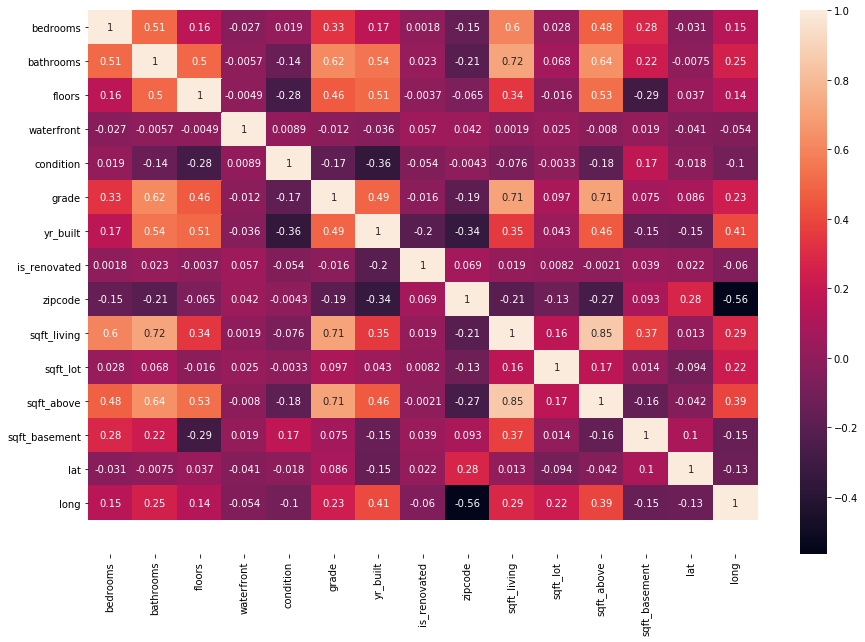

In [22]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(new_data[cat_cols + con_cols + geo_cols].corr(), annot=True)
ax.set_ylim(16,0)

I can see that some features have high correlations (above 0.70): Bathrooms + sqft, grade & sqft, sqft above and sqft living. I'll keep this in mind for feature engineering, but first I'm going to run a 'baseline' model.

## Modeling

### First 'Substandard' Model & Evaluation

Before I go into feature selection, I'll quickly run a basic model. Since CRISP-DM is an iterative process, I'll start with this and then circle back as many times as necessary to get the results I'm looking for.

Using Scikit Learn, I'm going to use a pretty standard train-test split of 70/30, scale my data, and fit it to a model. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, y, test_size=0.3, random_state=46)

#using a min max scaler so I can interpret coefficients by having all variables on the same scale
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
#initializing linear regression and fitting my model
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

#obtaining predicted values for both train and test data
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [26]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 118975.87577732376
Test Root Mean Squarred Error: 118972.7880517594
Train R2: 0.6806682255348756
Test R2: 0.685984020327101


I'm choosing to use RMSE as an indicator of how much error I have, and R2 score as an indication of how accurate my model will be. My R2 score actually isn't terrible, as it accounts for 68% of the variance in the data, and the train & test are close to each other. 

However, there is a lot of error that could affect predictions, and I'd like to improve the accuracy of the model. 

Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with transforming the continuous variables, since all look non-normal, and then address the multicollinearity. I also want to adjust location-related variables to make sure they are being usefully interpreted.

## Back to Data Preparation

My next step is to normalize continuous columns. Since this is mainly the sqft columns, I'm going to log transform them, but also eliminate some due to multicollinearity.

I saw in my heatmap that these columns had high correlations with eachother, and looking at their definitions this makes sense:

* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement

Sqft_living has high correlation with sqft_above, because sqft_living = sqft_above + sqft_basement, and not all houses have basements. 

Since sqft_living had one of the highest coefficients in my baseline model, I'm not going to use sqft_above so that we are factoring in the total size of the house, and the total size of the lot. I am going to remove the sqft_basement column and add a binary indicator, has_basement, since the total area will be captured in sqft_living.

In [27]:
#log transforming the columns I am using

new_data['sqft_living_log'] = np.log1p(data["sqft_living"])
new_data['sqft_lot_log'] = np.log1p(data["sqft_lot"])

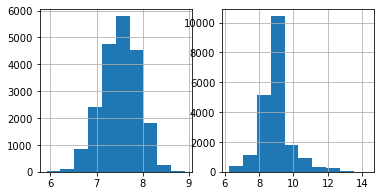

In [28]:
#previewing the distribution of the logged columns with histograms

plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 2, 1)
new_data['sqft_living_log'].hist();

ax2 = plt.subplot(1,2,2)
new_data['sqft_lot_log'].hist();

The distributions aren't perfect but they definitely look more normal. Now I'll add a basement indicator, concatenate all the X columns I'm using, and re-check correlations.

In [29]:
#new column  
new_data['has_basement'] = 0

# loop through the data and input a 1 where there is a basement
for row in new_data.index:
    if new_data['sqft_basement'][row] != 0:
        new_data['has_basement'][row] = 1

In [30]:
new_X = pd.concat([new_data[geo_cols], new_data['sqft_living_log'], new_data['sqft_lot_log'], new_data['has_basement'], new_data[cat_cols]], axis=1)

In [31]:
#checking high multicollinearity again
new_X.corr() > 0.70

lat   long  sqft_living_log  sqft_lot_log  has_basement  \
lat               True  False            False         False         False   
long             False   True            False         False         False   
sqft_living_log  False  False             True         False         False   
sqft_lot_log     False  False            False          True         False   
has_basement     False  False            False         False          True   
bedrooms         False  False            False         False         False   
bathrooms        False  False             True         False         False   
floors           False  False            False         False         False   
waterfront       False  False            False         False         False   
condition        False  False            False         False         False   
grade            False  False            False         False         False   
yr_built         False  False            False         False         False   
is_renovated     False  False            False         False         False   
zipcode          False  False            False         False         False   

                 bedrooms  bathrooms  floors  waterfront  condition  grade  \
lat                 False      False   False       False      False  False   
long                False      False   False       False      False  False   
sqft_living_log     False       True   False       False      False  False   
sqft_lot_log        False      False   False       False      False  False   
has_basement        False      False   False       False      False  False   
bedrooms             True      False   False       False      False  False   
bathrooms           False       True   False       False      False  False   
floors              False      False    True       False      False  False   
waterfront          False      False   False        True      False  False   
condition           False      False   False       False       True  False   
grade               False      False   False       False      False   True   
yr_built            False      False   False       False      False  False   
is_renovated        False      False   False       False      False  False   
zipcode             False      False   False       False      False  False   

                 yr_built  is_renovated  zipcode  
lat                 False         False    False  
long                False         False    False  
sqft_living_log     False         False    False  
sqft_lot_log        False         False    False  
has_basement        False         False    False  
bedrooms            False         False    False  
bathrooms           False         False    False  
floors              False         False    False  
waterfront          False         False    False  
condition           False         False    False  
grade               False         False    False  
yr_built             True         False    False  
is_renovated        False          True    False  
zipcode             False         False     True

My continuous variables look more normal and I've gotten rid of high multicollinearity except between bathrooms and sqft living.

Since I haven't addressed categorical variables I'm going to examine the location-related ones and then look at year built. 

Zipcode and lat/long are both indicators of location so I want to examine these a little closer and see if I can make them more useful, especially because I know these are being read incorrectly as numerical values. To get an idea of what the locations of these houses look like, I'm going to plot them.

In [32]:
import plotly.graph_objects as go

#create a scatter geo plot with lat/long coordinates from my dataframe

fig = go.Figure(data=go.Scattergeo(lon = new_data['long'], lat = new_data['lat'], mode = 'markers'))

fig.update_layout(
        title = 'Kings County Houses',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True))

# defining where to zoom in by taking the median of both coordinate columns making that the center
lat_foc = new_data['lat'].median()
lon_foc = new_data['long'].median()
fig.update_layout(
        geo = dict(
            projection_scale=26, #how much to zoom in 
            center=dict(lat=lat_foc, lon=lon_foc)))

fig.show()
# plt.savefig('Images/house_map_scatter')

<Figure size 432x288 with 0 Axes>

It's clear from this map that there are some outlier houses that are far from the center of town. Assuming distance from the center is a factor in price, I'm going to create a column to reflect that. I'm going to use the mpu library which has a haversine distance feature that can calculate the distance between two sets of lat/long coordinates in kilometers.

In [33]:
import mpu

#creating a new column that contains the lat & long of each row as a tupule
new_data['lat_long'] = list(zip(new_data.lat, new_data.long))

# official coordinates of seattle
seattle_center = (47.6062, 122.3321)

#creating another column that will calculate the distance between each house and the center of the city

new_data['dist_from_city'] = 0

for row in new_data.index:
    house_loc = new_data['lat_long']
    new_data['dist_from_city'][row] = mpu.haversine_distance(seattle_center, house_loc[row])

Since the distribution of the distance data is non-normal, I'm going to normalize and add to my continuous variables. I'll remove the original lat & long columns, as well as zipcode since I am using distance from city center as my location variable. 

In [34]:
new_X['dist_log'] = np.log1p(new_data['dist_from_city'])

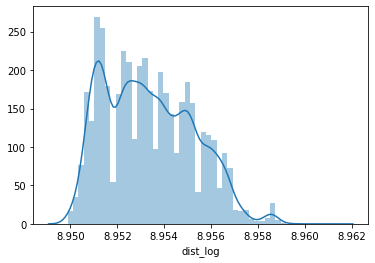

In [35]:
sns.distplot(new_X['dist_log'])

In [36]:
new_X = new_X.drop(['zipcode'], axis=1)
new_X = new_X.drop(['lat'], axis=1)
new_X = new_X.drop(['long'], axis=1)
new_X.columns

Index(['sqft_living_log', 'sqft_lot_log', 'has_basement', 'bedrooms',
       'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built',
       'is_renovated', 'dist_log'],
      dtype='object')

### Second Model

I'm going to run the model again to see if it's improved, and this time I also want to log my Y in the model knowing that its distribution is skewed. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=46)

#log y train and y test when running model
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#continue to use min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_2 = scaler.transform(X_train)
X_test_scaled_2 = scaler.transform(X_test)

#initiate and run model with logged and scaled data
lr_log = LinearRegression()
model2 = lr_log.fit(X_train_scaled_2, y_train_log)

In [38]:
# run predictions with logged data
y_hat_train_log = lr_log.predict(X_train_scaled_2)
y_hat_test_log = lr_log.predict(X_test_scaled_2)

#then undo the log in order to interpret scores
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)

In [39]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 126899.40810379043
Test Root Mean Squarred Error: 127320.07874993642
Train R2: 0.6367183122910214
Test R2: 0.6403746745283532


Interestingly, logging the Y, on top of the other updates, made my model slightly worse. The test R2 score also seems to be slightly higher than the training data, suggesting the model is underfit.

I'm going to take a look at the effect that different features are showing using the coefficients. I am also going to use Recursive Feature Elimination (RFE) from Scikit learn, which will help automate feature selection by training the data on each feature and analyzing its importance. 

To start off I'm going to tell it to select 10 of my 12 current features.

In [40]:
from sklearn.feature_selection import RFE

selector = RFE(linreg, n_features_to_select=10)
selector = selector.fit(new_X, y)
dict(zip(new_X.columns, selector.support_ ))

{'sqft_living_log': True,
 'sqft_lot_log': True,
 'has_basement': False,
 'bedrooms': True,
 'bathrooms': True,
 'floors': True,
 'waterfront': True,
 'condition': True,
 'grade': True,
 'yr_built': False,
 'is_renovated': True,
 'dist_log': True}

It doesn't like my binary indicator columns has_basement and doesnt see a strong effect from yr_built. I'll reconsider how I could make those variables more useful.

In [41]:
coefficients = linreg.coef_
coef_dict = dict(list(zip(new_X.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

0
floors           753916.163445
yr_built         544778.770861
bedrooms         265257.804342
is_renovated     192987.597132
sqft_lot_log     162618.583787
dist_log         161514.107895
bathrooms         97648.452333
has_basement      64862.918323
condition         28922.756074
grade            -46965.414627
sqft_living_log -120299.292609
waterfront      -219539.421353

Has_basement also has one of the lower coefficients, as do condition and grade, two of the rankings that came with the data. I don't have a ton of insight into how these were determined, but condition may not be really important to my business case, knowing that I am building new houses and they will be in good condition. I did some research on how the grade is determined, and based on its definition in seems like a helpful metric to keep in my data, as it refers to construction.  

*Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value*

source: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#g

Since my test data got worse in my second model, I am going to take a look at residuals and see if I can identify any trends. 

In [42]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

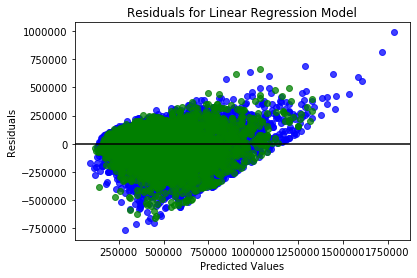

In [43]:
plt.scatter(y_hat_train, train_residuals, color='b', alpha=.75)
plt.scatter(y_hat_test, test_residuals, color='g', alpha=.75)

plt.axhline(y=0, color='black')

plt.title('Residuals for Linear Regression Model')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')
plt.show()

In [44]:
train_resid_df = X_train
train_resid_df['residuals'] = train_residuals
train_resid_df['price'] = y
train_resid_df.describe()

sqft_living_log  sqft_lot_log  has_basement      bedrooms  \
count     14350.000000  14350.000000  14350.000000  14350.000000   
mean          7.515384      8.966109      0.375819      3.327038   
std           0.398274      0.900078      0.484350      0.880647   
min           5.916202      6.350886      0.000000      1.000000   
25%           7.244942      8.517393      0.000000      3.000000   
50%           7.528869      8.923258      0.000000      3.000000   
75%           7.800163      9.244838      1.000000      4.000000   
max           8.920122     13.887104      1.000000     10.000000   

          bathrooms        floors    waterfront     condition         grade  \
count  14350.000000  14350.000000  14350.000000  14350.000000  14350.000000   
mean       2.055366      1.474599      0.002787      3.411498      7.541115   
std        0.712593      0.537174      0.052725      0.649713      1.043457   
min        0.500000      1.000000      0.000000      1.000000      3.000000   
25%        1.500000      1.000000      0.000000      3.000000      7.000000   
50%        2.000000      1.000000      0.000000      3.000000      7.000000   
75%        2.500000      2.000000      0.000000      4.000000      8.000000   
max        7.500000      3.500000      1.000000      5.000000     12.000000   

           yr_built  is_renovated      dist_log      residuals         price  
count  14350.000000  14350.000000  14350.000000   14350.000000  1.435000e+04  
mean    1970.862718      0.029477      8.953347  -14288.157706  4.795506e+05  
std       29.183441      0.169146      0.001885  126096.853130  2.105489e+05  
min     1900.000000      0.000000      8.949884 -763041.547218  8.995000e+04  
25%     1952.000000      0.000000      8.951699  -85441.088687  3.170000e+05  
50%     1974.000000      0.000000      8.953123   -1061.152062  4.390000e+05  
75%     1996.000000      0.000000      8.954803   65524.946979  6.050000e+05  
max     2015.000000      1.000000      8.959697  988524.036171  1.150000e+06

In [45]:
#where are residuals lower than the mean, aka significantly undepredicting
train_resid_df[train_resid_df['residuals']<= -15000].describe()

sqft_living_log  sqft_lot_log  has_basement     bedrooms    bathrooms  \
count      6487.000000   6487.000000   6487.000000  6487.000000  6487.000000   
mean          7.531918      8.940032      0.386774     3.336673     2.080199   
std           0.407925      0.976077      0.487049     0.918067     0.704550   
min           5.916202      6.459904      0.000000     1.000000     0.750000   
25%           7.259116      8.432289      0.000000     3.000000     1.750000   
50%           7.555382      8.834919      0.000000     3.000000     2.250000   
75%           7.832411      9.236106      1.000000     4.000000     2.500000   
max           8.692994     13.839294      1.000000    10.000000     5.000000   

            floors   waterfront    condition        grade     yr_built  \
count  6487.000000  6487.000000  6487.000000  6487.000000  6487.000000   
mean      1.493526     0.002775     3.402497     7.608294  1970.618159   
std       0.531643     0.052607     0.647355     1.043139    31.628620   
min       1.000000     0.000000     1.000000     3.000000  1900.000000   
25%       1.000000     0.000000     3.000000     7.000000  1948.000000   
50%       1.500000     0.000000     3.000000     7.000000  1975.000000   
75%       2.000000     0.000000     4.000000     8.000000  2001.000000   
max       3.500000     1.000000     5.000000    11.000000  2015.000000   

       is_renovated     dist_log      residuals         price  
count   6487.000000  6487.000000    6487.000000  6.487000e+03  
mean       0.029752     8.953279 -120056.357140  5.941815e+05  
std        0.169915     0.001806   93926.150844  1.997211e+05  
min        0.000000     8.949884 -763041.547218  1.560000e+05  
25%        0.000000     8.951829 -159284.262981  4.450000e+05  
50%        0.000000     8.952993  -96064.880767  5.700000e+05  
75%        0.000000     8.954286  -51217.749641  7.250000e+05  
max        1.000000     8.959697  -15025.789716  1.150000e+06

In [46]:
#taking the opposite approach using the absolute value of the mean, where is the model overpredicting
train_resid_df[train_resid_df['residuals']>= 15000].describe()

sqft_living_log  sqft_lot_log  has_basement     bedrooms    bathrooms  \
count      6311.000000   6311.000000   6311.000000  6311.000000  6311.000000   
mean          7.523340      9.006971      0.377119     3.341943     2.058311   
std           0.386782      0.833129      0.484704     0.849171     0.722684   
min           6.311735      6.350886      0.000000     1.000000     0.500000   
25%           7.259116      8.674368      0.000000     3.000000     1.500000   
50%           7.534228      8.980046      0.000000     3.000000     2.000000   
75%           7.791936      9.263881      1.000000     4.000000     2.500000   
max           8.920122     13.887104      1.000000     9.000000     7.500000   

            floors   waterfront    condition        grade     yr_built  \
count  6311.000000  6311.000000  6311.000000  6311.000000  6311.000000   
mean      1.465061     0.003011     3.416099     7.539059  1970.816986   
std       0.544100     0.054791     0.646007     1.048440    26.548833   
min       1.000000     0.000000     1.000000     4.000000  1900.000000   
25%       1.000000     0.000000     3.000000     7.000000  1954.000000   
50%       1.000000     0.000000     3.000000     7.000000  1972.000000   
75%       2.000000     0.000000     4.000000     8.000000  1991.000000   
max       3.500000     1.000000     5.000000    12.000000  2015.000000   

       is_renovated     dist_log      residuals         price  
count   6311.000000  6311.000000    6311.000000  6.311000e+03  
mean       0.030898     8.953332   90781.322122  3.795098e+05  
std        0.173056     0.001918   66893.680444  1.700474e+05  
min        0.000000     8.949884   15006.307678  8.995000e+04  
25%        0.000000     8.951440   43444.259282  2.606750e+05  
50%        0.000000     8.953381   74844.803746  3.400000e+05  
75%        0.000000     8.955061  119885.487901  4.500000e+05  
max        1.000000     8.958926  988524.036171  1.150000e+06

Looking at differences in the means, I'm not seeing any major underlying trends, except that my model is underpredicting higher priced houses (mean of \$594k) and underpredicting middle priced houses (mean of \$379k). I'm going to look for ways to make it more clear to identify value. 

### Third Model

Aiming to increase the accuracy of my model, I'm going to work on some features that don't seem to be having the effect they should be. As a recap:

- Grade has a low coefficient but seems important
- Waterfront has a very negative coefficient, but there are  very few houses identified as on waterfront so this may be innacurate
- Binary columns don't seem to be helping

First I'll take a closer look at grade.

In [47]:
new_data['grade'].describe()

count    20501.000000
mean         7.539096
std          1.042462
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: grade, dtype: float64

I'm not sure what the scale of housing grades are, but my data is between 3-12 with a mean of 7. I'm going to try sorting this into categories of poor, average, and high. Since there is a standard deviation of 1 I am going to make some assumptions in the ranking. 

In [48]:
#new column
new_data['grade_rank'] = 0

#use a for loop to sort the numerical grades into category groups
for row in new_data.index:
    if new_data['grade'][row] <= 5:
        new_data['grade_rank'][row] = 'poor'
    elif new_data['grade'][row] in range(6,9):
        new_data['grade_rank'][row] = 'avg'
    elif new_data['grade'][row] in range(10,12):
        new_data['grade_rank'][row] = 'high'

I will now use one hot encoding to add dummy columns for each category for modeling

In [49]:
grade_dummies = pd.get_dummies(new_data['grade_rank'], prefix='grade', drop_first=True)

In [50]:
X_third = pd.concat([new_X, grade_dummies], axis=1)

Next I am going to rethink 'is_renovated' with a years since updated column that will take into account year built and year renovated. I'm going to add this column to my X variables, remove the ones that I'm replacing, and remove the innacurate or unnecessary ones (condition and waterfront).

In [51]:
new_data['yrs_since_updated'] = 0

for row in new_data.index:
    if new_data['yr_renovated'][row] > new_data['yr_built'][row]:
        new_data['yrs_since_updated'][row] = (2020 - new_data['yr_renovated'][row])
    elif new_data['yr_renovated'][row] == 0:
        new_data['yrs_since_updated'][row] = (2020 - new_data['yr_built'][row])

In [52]:
X_third = X_third.drop(['condition', 'grade', 'waterfront', 'yr_built', 'is_renovated'], axis=1)
X_third = pd.concat([X_third, new_data[['yrs_since_updated']]], axis=1)

Running the model again, I am reducing the test size a bit and not logging the y.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_third, y, test_size=0.25, random_state=46)

#continue to use min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_3 = scaler.transform(X_train)
X_test_scaled_3 = scaler.transform(X_test)

#initiate and run model with scaled data
linreg = LinearRegression()
model3 = linreg.fit(X_train_scaled_3, y_train)

In [54]:
#obtaining predicted values for both train and test data
y_hat_train = linreg.predict(X_train_scaled_3)
y_hat_test = linreg.predict(X_test_scaled_3)

In [55]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 131307.7958844671
Test Root Mean Squarred Error: 133176.15789888724
Train R2: 0.6109009235103713
Test R2: 0.6082254379181764


R2 decreased and error increased. Running the coefficients again, I'm going to remove has_basement and do something about bedrooms since that variable now looks negative.

In [56]:
coefficients = linreg.coef_
# coefficients = abs(coefficients)
coef_dict = dict(list(zip(X_third.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

0
sqft_living_log    782513.111358
bathrooms          235068.777131
yrs_since_updated  132827.385488
grade_high          84802.416442
floors              59866.592608
sqft_lot_log        59403.990789
has_basement        -2937.443156
grade_poor        -143421.274056
grade_avg         -145049.351152
bedrooms          -174823.591524
dist_log          -470199.610833

### Fourth Model

Looking at these coefficients, I'm surprised that bedrooms is so negative. This variable does seem to have some outliers - I got rid of one 'house' with 33 bedrooms, but there are still a lot with a high number of rooms that don't seem realistic for a single family home.

According to census data, of the 903,000 single-family homes completed in 2019, 102,000 had two bedrooms or less and 386,000 had four bedrooms or more. That's more than I'd expected, but I can see my data drop off after 5. 

Source: https://www.census.gov/construction/chars/highlights.html

In [66]:
new_data['bedrooms'].value_counts()

3     9608
4     6342
2     2730
5     1346
6      234
1      194
7       30
8        9
9        4
10       3
11       1
Name: bedrooms, dtype: int64

In [67]:
X_four = X_third[X_third['bedrooms'] < 6]

In [68]:
X_four['bedrooms'].value_counts()

3    9608
4    6342
2    2730
5    1346
1     194
Name: bedrooms, dtype: int64

In [69]:
final_data = new_data[new_data['bedrooms'] < 6]
new_y = final_data['price']

Now I'll run my final model.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_four, new_y, test_size=0.25, random_state=46)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_4 = scaler.transform(X_train)
X_test_scaled_4 = scaler.transform(X_test)
model4 = linreg.fit(X_train_scaled_4, y_train)

In [71]:
y_hat_train = linreg.predict(X_train_scaled_4)
y_hat_test = linreg.predict(X_test_scaled_4)

In [72]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [73]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 131595.20843718108
Test Root Mean Squarred Error: 130003.5515734503
Train R2: 0.6063640356347575
Test R2: 0.6212266935829878


## Final Evaluation & Conclusions

My final model reflects aspects of the data that are helpful in answering my business question - which features should a moderately priced home aimed at middle class buyers in 2021 include?

Features were appropriatley added and removed where relevant to this question, and were adapted to fit to a linear regression model. 

In [74]:
coefficients = linreg.coef_
coef_dict = dict(list(zip(X_third.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

0
sqft_living_log    762300.580416
bathrooms          202997.350039
yrs_since_updated  135325.647299
grade_high          90388.603481
floors              59479.112399
sqft_lot_log        58470.348454
has_basement        -4060.453893
bedrooms           -77978.681077
grade_avg         -144437.206800
grade_poor        -144908.909452
dist_log          -471471.424592

### Business Recommendations

My final model shows that the features that have the highest effect on single family homes between \$89K and \$1.15MM are square foot of the living area, number of bathrooms, grade of construction , and recency of updates on a house.

The value is significantly decreased where construction grade is average or low, and the house is further away from the city center. 

Whether or not the house has a basement has little effect.

The developers are recommended to:

#### - Focus on maximizing the living area of the house ####
#### - Use high quality construction methods - this may increase the budget but will be worth the investment
#### - Build multi-floor homes and include ample bathrooms

### Technical Recommendations & Future Work

If there is further work on this project, I would recommend continuing to engineer features of the model in order to improve the R2 score and decrease error. Although I didn't detect any interactions, I would recommend looking more into how the features interact and relate to each other. 

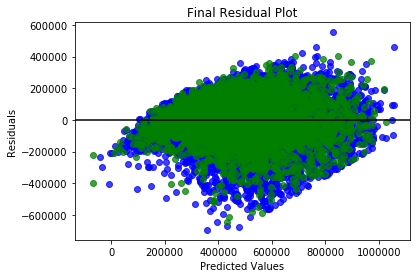

In [65]:
plt.scatter(y_hat_train, train_residuals, color='b', alpha=.75)
plt.scatter(y_hat_test, test_residuals, color='g', alpha=.75)

plt.axhline(y=0, color='black')

plt.title('Final Residual Plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')
plt.show()

From a data gathering perspective, I would recommend using more recent data and also increase the range to be more than 2 years in order to examine a wider range of trends. It would also be interesting to look at data from another time when the housing market surged in a similar way to see if any trends were consistent. 

To make the model more generalizable, it would also be interesting to include data from multiple markets to see what trends are local vs specific to this market and potentially build multiple models to show the differences.

### Conclusion

While the data cleaning and transformations I made to this data followed best practices to fit it to a linear regression model, it didn't end up as accurate as I would have hoped. However, I was able to inform my business question by defining features of a home that would be important to a certain segment of buyers and eliminating many that do not prove to affect price.

# Thank you!